In [3]:
%load_ext autoreload
%autoreload 2

if __name__ == '__main__':
    import sys
    import os
    from pathlib import Path
    curr_file_path = Path(os.path.abspath(''))
    print(curr_file_path)
    sys.path.append(str(curr_file_path.parent))
    sys.path.append(os.path.join(str(curr_file_path.parent.parent.parent), 'fixed-point-finder'))

import chex
from jax import random
from environments.treadmill_env_jax import TreadmillEnvironment, TreadmillEnvParams, treadmill_session_default_params  # adjust this import

import torch
from agents.networks.a2c_rnn_split_vanilla import A2CRNN
from agents.a2c_recurrent_agent_split import A2CRecurrentAgent

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
/home/david.bell/work/favorably_connected_2/code/notebooks


=== OBSERVATION SUMMARY ===
Total steps: 2000
Visual cue active: 99.7% of time
Odor 0 active: 0.3% of time
Odor 1 active: 0.0% of time
Odor 2 active: 83.7% of time
Total rewards: 57.0
Time in patches: 99.7%

Dwell time stats:
  Max dwell time: 9
  Mean dwell time: 4.2
  Dwell time >= 6: 37.2% of time

Patch distribution:
  Patch 0: 13 steps (0.7%)
  Patch 1: 0 steps (0.0%)
  Patch 2: 1987 steps (99.4%)


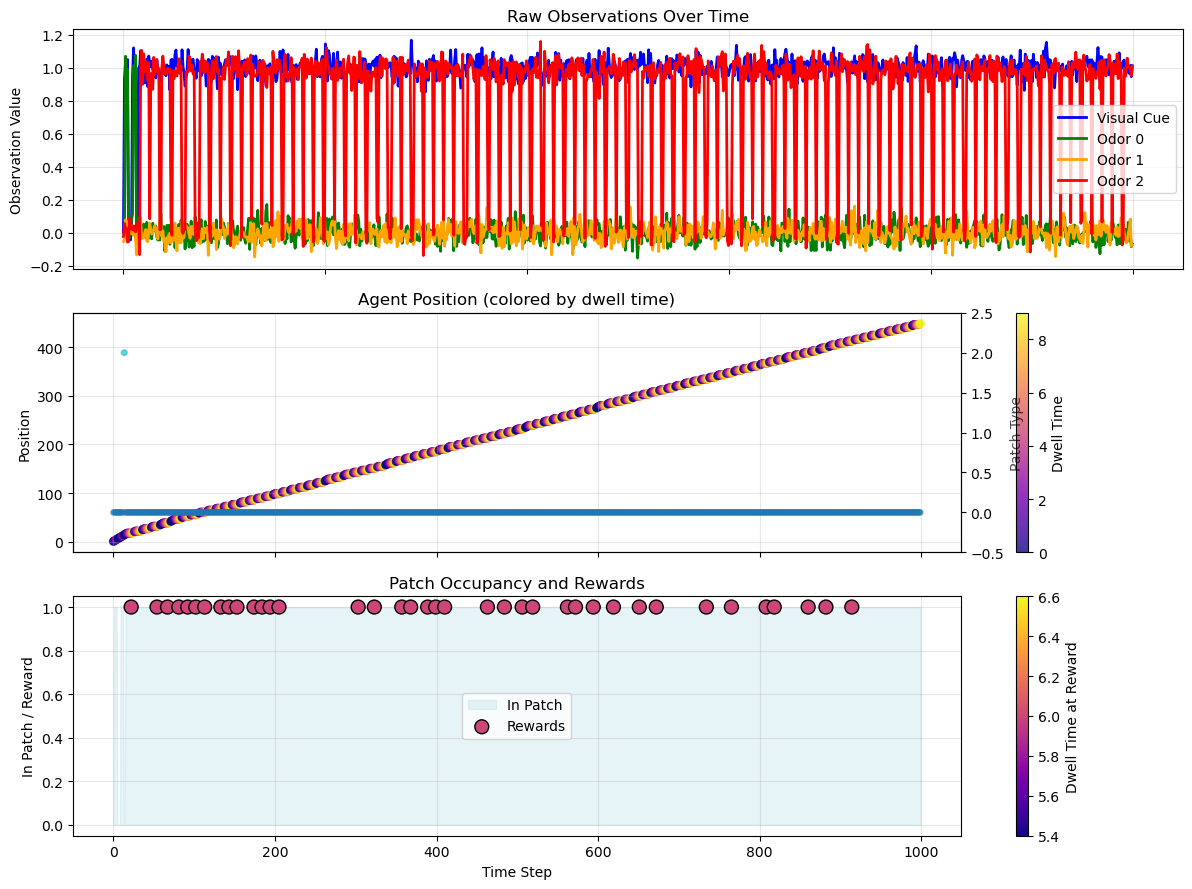

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import jax
import jax.numpy as jnp
from jax import random

# Import your environment (assuming the code is in a file called treadmill_env.py)
# from treadmill_env import TreadmillEnvironment, treadmill_session_default_params

def collect_observations(env_reset, env_step, params, num_steps=1000, seed=100):
    """Run the environment and collect observations"""
    
    key = random.PRNGKey(seed)
    key, reset_key = random.split(key)
    
    # Reset environment
    obs, state = env_reset(reset_key, params)
    
    # Storage for data
    observations = []
    positions = []
    patches = []
    rewards = []
    actions = []
    in_patch = []
    dwell_times = []

    dwell = 0
    
    for step in range(num_steps):
        # Choose random action (0 = stay, 1 = move forward)
        action = 1  # 70% chance to move
        
        # Take step
        key, step_key = random.split(key)
        if jnp.any(obs[2:] > 0.5):
            if dwell < 6:
                action = 0
            dwell += 1
        else:
            dwell = 0
        obs, state, reward, done, info = env_step(step_key, state, action, params)
            
        
        # Store data
        observations.append(np.array(obs))
        positions.append(float(info['current_position']))
        patches.append(int(info['current_patch_num']))
        rewards.append(float(reward))
        actions.append(int(action))
        in_patch.append(bool(info['agent_in_patch']))
        dwell_times.append(int(state.dwell_time))
    
    return {
        'observations': np.array(observations),
        'positions': np.array(positions),
        'patches': np.array(patches),
        'rewards': np.array(rewards),
        'actions': np.array(actions),
        'in_patch': np.array(in_patch),
        'dwell_times': np.array(dwell_times)
    }


def plot_observations(data, start_step=0, num_steps=200):
    """Plot the observations and environment state"""
    
    end_step = min(start_step + num_steps, len(data['observations']))
    steps = np.arange(start_step, end_step)
    
    obs = data['observations'][start_step:end_step]
    positions = data['positions'][start_step:end_step]
    patches = data['patches'][start_step:end_step]
    rewards = data['rewards'][start_step:end_step]
    in_patch = data['in_patch'][start_step:end_step]
    patches[in_patch] = 0
    dwell_times = data['dwell_times'][start_step:end_step]
    
    fig, axes = plt.subplots(3, 1, figsize=(12, 9), sharex=True)
    
    # Plot 1: Raw observations
    axes[0].plot(steps, obs[:, 0], label='Visual Cue', linewidth=2, color='blue')
    axes[0].plot(steps, obs[:, 1], label='Odor 0', linewidth=2, color='green')
    axes[0].plot(steps, obs[:, 2], label='Odor 1', linewidth=2, color='orange')
    axes[0].plot(steps, obs[:, 3], label='Odor 2', linewidth=2, color='red')
    axes[0].set_ylabel('Observation Value')
    axes[0].set_title('Raw Observations Over Time')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    
    # Plot 2: Position colored by dwell time
    scatter = axes[1].scatter(steps, positions, c=dwell_times, cmap='plasma', 
                             s=30, alpha=0.8)
    axes[1].set_ylabel('Position')
    axes[1].set_title('Agent Position (colored by dwell time)')
    axes[1].grid(True, alpha=0.3)
    
    # Add colorbar for dwell time
    cbar1 = plt.colorbar(scatter, ax=axes[1])
    cbar1.set_label('Dwell Time')
    
    # Add patch info on secondary y-axis
    ax1_twin = axes[1].twinx()
    ax1_twin.scatter(steps, patches, c=patches, cmap='tab10', alpha=0.4, s=15)
    ax1_twin.set_ylabel('Patch Type', alpha=0.7)
    ax1_twin.set_ylim(-0.5, 2.5)
    
    # Plot 3: Patch occupancy and rewards
    axes[2].fill_between(steps, 0, in_patch, alpha=0.3, color='lightblue', label='In Patch')
    
    # Show rewards colored by dwell time
    reward_mask = rewards > 0
    if np.any(reward_mask):
        reward_steps = steps[reward_mask]
        reward_values = rewards[reward_mask]
        reward_dwell = dwell_times[reward_mask]
        
        reward_scatter = axes[2].scatter(reward_steps, reward_values, 
                                       c=reward_dwell, cmap='plasma',
                                       s=100, label='Rewards', zorder=5,
                                       edgecolors='black', linewidth=1)
        
        # Add colorbar for reward dwell times
        cbar2 = plt.colorbar(reward_scatter, ax=axes[2])
        cbar2.set_label('Dwell Time at Reward')
    
    axes[2].set_ylabel('In Patch / Reward')
    axes[2].set_xlabel('Time Step')
    axes[2].set_title('Patch Occupancy and Rewards')
    axes[2].legend()
    axes[2].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()


def summary_stats(data):
    """Print summary statistics"""
    obs = data['observations']
    
    print("=== OBSERVATION SUMMARY ===")
    print(f"Total steps: {len(obs)}")
    print(f"Visual cue active: {np.mean(obs[:, 0] > 0.5):.1%} of time")
    print(f"Odor 0 active: {np.mean(obs[:, 1] > 0.5):.1%} of time")
    print(f"Odor 1 active: {np.mean(obs[:, 2] > 0.5):.1%} of time") 
    print(f"Odor 2 active: {np.mean(obs[:, 3] > 0.5):.1%} of time")
    print(f"Total rewards: {np.sum(data['rewards'])}")
    print(f"Time in patches: {np.mean(data['in_patch']):.1%}")
    
    # Dwell time stats
    print(f"\nDwell time stats:")
    print(f"  Max dwell time: {np.max(data['dwell_times'])}")
    print(f"  Mean dwell time: {np.mean(data['dwell_times']):.1f}")
    print(f"  Dwell time >= 6: {np.mean(data['dwell_times'] >= 6):.1%} of time")
    
    # Patch distribution
    patch_counts = np.bincount(data['patches'])
    print("\nPatch distribution:")
    for i, count in enumerate(patch_counts):
        print(f"  Patch {i}: {count} steps ({count/len(data['patches']):.1%})")


# Example usage:
if __name__ == "__main__":
    # Create a PRNG key
    key = random.PRNGKey(43)
    
    # Instantiate environment with default params
    params = treadmill_session_default_params()
    reset, step = TreadmillEnvironment()
    
    # Collect data
    # print("Collecting observations...")
    data = collect_observations(reset, step, params, num_steps=2000)
    
    # Show summary
    summary_stats(data)
    
    # Plot different time windows
    plot_observations(data, start_step=0, num_steps=1000)
    # plot_observations(data, start_step=500, num_steps=200)
